In [1]:
!pip install -qU langchain-community faiss-cpu langchain-google-genai PyMuPDF langchain-groq langgraph google-ai-generativelanguage==0.6.15

# Vector Database with Faiss

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [48]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world"))) #to get the length vector

# initiate Faiss VectorDB
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [50]:
# store document to the vector database

from uuid import uuid4

from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)


documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))] #unique ID for querying - look for the most similar

vector_store.add_documents(documents=documents, ids=uuids)

['5908dd73-e8dd-49f5-a20d-7e2d4525ce5c',
 '411ecdbd-0ce7-48d3-ac7b-f960de6acd53',
 'f4adbcb9-79ea-4f05-afce-dfad59e0c791',
 '7484fea8-268b-4a78-b2b0-dc34871cc012',
 '5518af17-19f0-4a85-83fd-218c3dfec84d',
 'f57d8595-12b0-401c-8755-a741b3fa800f',
 '181b3503-7aab-4e13-a928-d4187823b78d',
 '5e32b494-3d5f-4588-a000-9024d73c0fca',
 'e145c191-3fb7-464a-a586-061ebf52ca48',
 'e4569f31-764b-4ca6-8a07-e3445fbd7f5c']

## Melakukan pencarian di FaissDB

Operator yang didukung untuk melakukan filtering adalah sebagai berikut:

- $eq (equals)

- $neq (not equals)

- $gt (greater than)

- $lt (less than)

- $gte (greater than or equal)

- $lte (less than or equal)

- $in (membership in list)

- $nin (not in list)

- $and (all conditions must match)

- $or (any condition must match)

- $not (negation of condition)

In [52]:
results = vector_store.similarity_search(
    "LangChain provides abstractions to make working with LLMs easy",
    k=2,
    filter={"source": {"$eq": "tweet"}},
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* LangGraph is the best framework for building stateful, agentic applications! [{'source': 'tweet'}]
* LangGraph is the best framework for building stateful, agentic applications! [{'source': 'tweet'}]


In [62]:
results = vector_store.similarity_search(
    "The new iPhone",
    k=2,
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")


'''
by default: searching based on similarity
we can also search for value, customized index filters; from "tweet"

'''

* Is the new iPhone worth the price? Read this review to find out. [{'source': 'website'}]
* Is the new iPhone worth the price? Read this review to find out. [{'source': 'website'}]


'\nby default: searching based on similarity\nwe can also search for value, customized index filters; from "tweet"\n\n'

FAISS
by default g ada file, all in memory. Save file, load the file.

1.   Bikin document chunk - untuk ke VEctorDB
2.   Add document - VectorDB embedding the document
3.   Retrieval


in conclusion:
bikin DB - embedding, configure, embed, docstore
add document
retrieval

in step 1. 1/multiple PDF documents





## Save the DB


In [63]:
vector_store.save_local("faiss_index")

## Load the DB

In [64]:
new_vector_store = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)

docs = new_vector_store.similarity_search("qux")

In [65]:
for res in docs:
    print(f"* {res.page_content} [{res.metadata}]")

* Building an exciting new project with LangChain - come check it out! [{'source': 'tweet'}]
* Building an exciting new project with LangChain - come check it out! [{'source': 'tweet'}]
* The stock market is down 500 points today due to fears of a recession. [{'source': 'news'}]
* The stock market is down 500 points today due to fears of a recession. [{'source': 'news'}]


# RAG dengan LangChain

In [66]:
from langchain.text_splitter import CharacterTextSplitter
from langchain_core.documents import Document
import fitz


### Langkah 1: Extract document dan chunk dokumen
Chunk ini dilakukan untuk mengubah dokumen yang panjang menjadi bagian bagian kecil sehingga text yang diterima LLM lebih sedikit. Tujuannya adalah karena adanya batasan token yang diberikan oleh LLM, selain itu semakin panjang text yang diterima oleh LLM semakin lama pula respons yang diberikan oleh LLM.

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
"""
def extract_text_from_pdf(pdf_path):
    """Mengekstrak teks dari PDF"""
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text() for page in doc])
    return text

pdf_text = extract_text_from_pdf("/content/nist.pdf")
'''

SyntaxError: unterminated triple-quoted string literal (detected at line 9) (ipython-input-2408122233.py, line 3)

In [71]:
def extract_text_from_pdfs(pdf_paths):
    """Mengekstrak teks dari beberapa PDF"""
    all_text = ""
    for pdf_path in pdf_paths:
        try:
            doc = fitz.open(pdf_path)
            all_text += "\n".join([page.get_text() for page in doc])
            doc.close() # Close the document after processing
        except Exception as e:
            print(f"Error extracting text from {pdf_path}: {e}")
    return all_text

# paths to PDF files in Google Drive
pdf_files = [
    "/content/drive/MyDrive/RAG/kms/nist_80053r5.pdf"
    "/content/drive/MyDrive/RAG/kms/fedramp.pdf",
    "/content/drive/MyDrive/RAG/kms/ir_windows.pdf",
    "/content/drive/MyDrive/RAG/kms/nist_1362.pdf",
]

pdf_text = extract_text_from_pdfs(pdf_files)

# You can print the first 500 characters to verify
print(pdf_text[:500])

Error extracting text from /content/drive/MyDrive/RAG/kms/nist_80053r5.pdf/content/drive/MyDrive/RAG/kms/fedramp.pdf: no such file: '/content/drive/MyDrive/RAG/kms/nist_80053r5.pdf/content/drive/MyDrive/RAG/kms/fedramp.pdf'

Incident Response for Windows
Adapt effective strategies for managing sophisticated 
cyberattacks targeting Windows systems
Anatoly Tykushin
Svetlana Ostrovskaya

Incident Response for Windows
Copyright © 2024 Packt Publishing
All rights reserved. No part of this book may be reproduced, stored in a retrieval system, or transmitted 
in any form or by any means, without the prior written permission of the publisher, except in the case 
of brief quotations embedded in critical articles or reviews.


In [75]:
document = Document(
    page_content=pdf_text
)

In [76]:
splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=1000,
    chunk_overlap=200
)


chunks = splitter.split_text(pdf_text) #you can also split documents using split_documents

In [77]:
# hasil chunk document

[chunk[:100] + '...' for chunk in chunks]

['Incident Response for Windows\nAdapt effective strategies for managing sophisticated \ncyberattacks ta...',
 'for any damages caused or alleged to have been caused directly or indirectly by this book.\nPackt Pub...',
 'Grosvenor House\n11 St Paul’s Square\nBirmingham\nB3 1RB, UK\nISBN 978-1-80461-932-2\nwww.packtpub.com\nTo...',
 'methods in a dynamic cyber world.\nAuthored by Svetlana Ostrovskaya and Anatoly Tykushin, experienced...',
 'can enhance incident response strategies. This integration aids in attributing attacks, anticipating...',
 'gleaned from the incident response to develop effective protection strategies.\nAdditionally, this bo...',
 'incident response, compromise assessment, and threat hunting. He has created several DFIR training \n...',
 'career at one of my homeland’s leading architecture and construction universities. Finally, I want \n...',
 'and incident response.\nI would like to express my gratitude to Anatoly for his passion and dedicatio...',
 'he specializ

### Langkah 2: Upload Chunked Documents ke Database

In [80]:
# Bikin VectorDB
#inisiasi faisdb
index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world"))) #untuk mendapatkan length vectornya

#initiate Faiss VectorDB
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [81]:
documents = [Document(page_content=chunk) for chunk in chunks]

In [82]:
uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['d3b5930b-98b7-43b1-be32-4855c3df4390',
 '74b85758-8dad-495a-8589-6547b819d0e7',
 '46ae450d-f2fd-42b5-ab00-93534d182ae3',
 '803db40b-5806-416f-9ebf-d7edea328f46',
 '5a2253be-2d4c-4f32-ae03-34fec72ca45e',
 '7c0ba491-8a16-44ef-ae67-fc00a71ea079',
 'd834e713-9563-405b-9819-e7f832633172',
 '1728d9c5-93cf-456f-a463-6cd439b56c32',
 '5d480ed6-977e-4db9-ab75-4b2bc2b193e2',
 '7ab656c8-0fe2-404b-9182-d80fb33f36ee',
 'bb23cdb5-0990-4be9-a03d-773a9f8ca56a',
 'a9351d11-8c26-469c-bb91-4365dd25b8d3',
 '2dbf6acf-cca0-43ea-8635-a9955b0a5ccf',
 '51c66a4b-bbda-4d54-9e8c-feb3bd667c44',
 '21995be4-851e-40ef-b9b4-9fcdd20a2660',
 '6b69583e-40f1-4eda-956e-5ad056728af3',
 'b88046da-69d4-40a4-8b94-48c21f7b49f5',
 'c88bea53-ea32-452b-8d90-a5bf5e352135',
 '8a1f6059-3df3-4434-b42c-7f34923b10bf',
 'fe1df0e8-4954-4373-91cb-a13d5d6c84d4',
 'c6ecda67-4f61-441b-923a-20a8f5a3607a',
 'f25c2f52-b7a9-4356-804d-00921e1e6967',
 '7fd0e368-4d0a-4682-afb2-b2414ffadd9f',
 'd3ab74a1-2d3f-4b34-8b81-a2c3d113e563',
 'de17baf9-f2cb-

In [83]:
vector_store.save_local("faiss_index")

### Langkah 3: Develop RAG

In [85]:
# Retrieve context DB -query- add to the context generation
# Initialize State

from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain_groq import ChatGroq


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [87]:
#initialize prompt

from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
# rlm/rag-prompt is from https://smith.langchain.com/hub/rlm/rag-prompt

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [96]:
# Initialize LLM

import os
from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get("groq")

MODEL = 'llama-3.3-70b-versatile'

llm = ChatGroq(
    temperature=0,
    model_name=MODEL
) # we can replace the model with gemini or other LLM

In [97]:
# Function for Retrival
# buat logic untuk mengambil informasi dari faissdb dan men-generate jawaban

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs} # getting context


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"]) # saving the context
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [98]:
# intialize flow
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

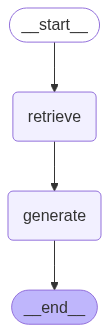

In [99]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
result = graph.invoke({"question": "what is Fedramp all about?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='7a1d04c0-998e-405e-bac4-aa8800a5caba', metadata={}, page_content='federal supply chains. \n• The Software and Supply Chain Assurance Forum provides a venue for \ngovernment, industry, and academic participants from around the world \nto share their knowledge and expertise regarding C-SCRM, supply chain \nrisks, effective practices and response strategies, tools and technologies, \nand any gaps related to the people, processes, or technologies involved. \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n  \n \n \n \n \n \n \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \nGLOSSARY \nDefinitions of Key Terms From This Due Diligence Assessment Quick-Start Guide \nThe 

In [101]:
result = graph.invoke({"question": "What are the key takeaways from Incident Response?"})
print(f'Answer: {result["answer"]}')

Answer: The key takeaways from Incident Response include documenting and improving processes, continuously updating role-specific manuals, and establishing a follow-up mechanism to ensure improvements are implemented. This helps in developing an effective incident response plan and improving the overall security posture. Additionally, sharing non-sensitive insights with relevant stakeholders and regularly reviewing and revising incident remediation playbooks can also contribute to a successful incident response.
